In [1]:
from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm

from functools import partial

import torch

from pyro.nn import AutoRegressiveNN, ConditionalAutoRegressiveNN

from pyro.distributions import constraints
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.distributions.transforms import SplineCoupling
from pyro.distributions.transforms.spline import ConditionalSpline

import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from torch.nn.parallel import DistributedDataParallel as DDP
from torch.multiprocessing import Process

import time
import h5py

from custom_pyro import ConditionalAffineCouplingTanH

from pyro.nn import ConditionalDenseNN, DenseNN, ConditionalAutoRegressiveNN
import pyro.distributions as dist
import pyro.distributions.transforms as T
device = torch.device('cuda:0')

In [8]:
def compile_HybridTanH_model(num_blocks, num_inputs, num_cond_inputs, device):
    # the latent space distribution: choosing a 2-dim Gaussian
    base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))

    input_dim = num_inputs
    count_bins = 8
    transforms = []
    transforms2 = []
      
    input_dim = num_inputs
    split_dim = num_inputs//2
    param_dims1 = [input_dim-split_dim, input_dim-split_dim]
    param_dims2 = [input_dim * count_bins, input_dim * count_bins, input_dim * (count_bins - 1), input_dim * count_bins]

    torch.manual_seed(42)

    for i in range(num_blocks):
        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        hypernet = DenseNN(num_cond_inputs, [input_dim*4, input_dim*4], param_dims2)
        ctf = T.ConditionalSpline(hypernet, input_dim, count_bins)
        transforms2.append(ctf)
        transforms.append(ctf)
        

        

        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        
    modules = nn.ModuleList(transforms2)

    flow_dist = dist.ConditionalTransformedDistribution(base_dist, transforms)

    return modules, flow_dist

In [9]:
model, distribution = compile_HybridTanH_model(8, 
                                           num_inputs=32, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs

In [10]:
default_params = {
    "batch_size" : 2048,
    "epochs" : 138,
    "shuffle" : True,
}

In [11]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

In [12]:
path = './data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k.hdf5'
energy = h5py.File(path, 'r')['energy'][:]
events = h5py.File(path, 'r')['events'][:]

num_points = (events[:][:, -1] > 0).sum(axis=1)
visible_energy = (events[:][:, -1]).sum(axis=1)

In [16]:
clusters_per_layer = [((events[:, 1, :] < i+1) & (events[:, 1, :] > i)).sum(axis=1) for i in range(30)]

clusters_per_layer = np.vstack(clusters_per_layer)

clusters_per_layer = np.moveaxis(clusters_per_layer, 0, -1)

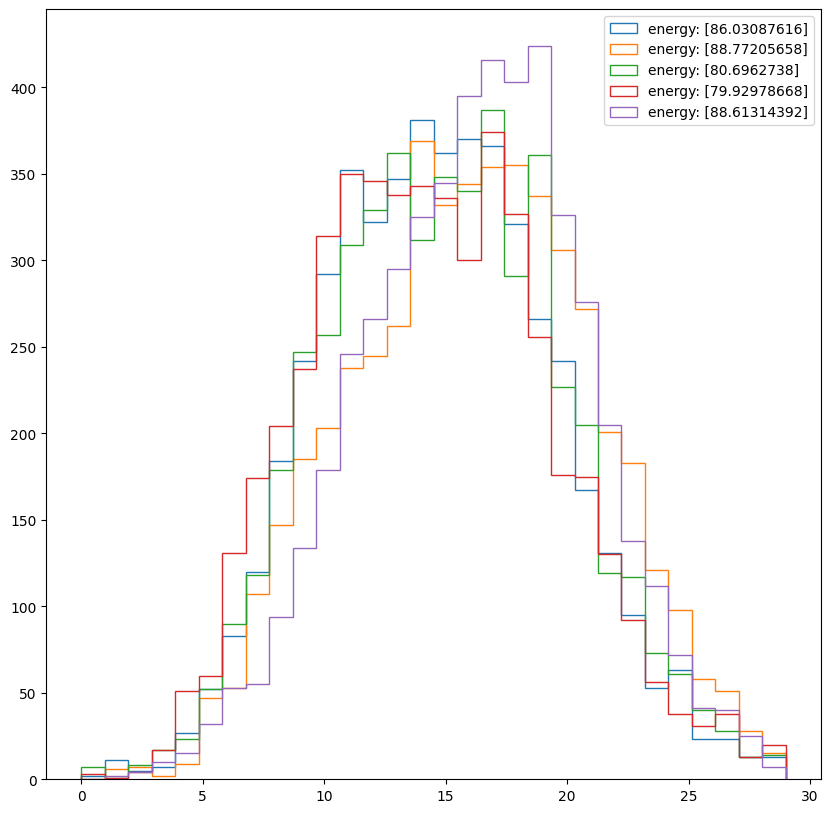

In [28]:
plt.figure(figsize=(10,10))
for i in range(500000, 500005):
    plt.hist(np.arange(30), weights=clusters_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=30)
plt.legend()
plt.show()

In [29]:
clusters_per_layer = clusters_per_layer / 400

df = pd.DataFrame([])
df['energy'] = energy[:].reshape(-1)
df['num_points'] = num_points / 5000
df['visible_energy'] = visible_energy * 1000 / 2.5 / 1000

df['clusters_per_layer'] = clusters_per_layer.tolist()

In [32]:
df

,energy,num_points,visible_energy,clusters_per_layer
0,15.620060,0.0326,0.018918,"[0.0, 0.0, 0.0, 0.0075, 0.0075, 0.01, 0.01, 0...."
1,41.926819,0.0472,0.039103,"[0.0125, 0.02, 0.0075, 0.02, 0.015, 0.035, 0.0..."
2,44.005219,0.0524,0.028260,"[0.0, 0.005, 0.0125, 0.025, 0.02, 0.01, 0.0225..."
3,10.890450,0.0586,0.042493,"[0.005, 0.01, 0.07, 0.0475, 0.03, 0.0325, 0.05..."
4,41.575275,0.0620,0.034748,"[0.01, 0.0075, 0.03, 0.02, 0.0275, 0.025, 0.05..."
...,...,...,...,...
524954,89.005737,1.1364,0.841660,"[0.025, 0.005, 0.095, 0.06, 0.19, 0.245, 0.355..."
524955,89.381836,1.1364,0.834334,"[0.0025, 0.0125, 0.0725, 0.095, 0.22, 0.4, 0.5..."
524956,88.777878,1.1378,0.865821,"[0.0, 0.025, 0.075, 0.06, 0.21, 0.3575, 0.405,..."
524957,88.592522,1.1378,0.817879,"[0.0025, 0.025, 0.0375, 0.095, 0.2175, 0.2775,..."


In [33]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(df.energy.values), 
    torch.tensor(df.num_points.values), 
    torch.tensor(df.visible_energy.values),
    torch.tensor(df.clusters_per_layer)
    )

In [34]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)


In [35]:
num_blocks = 10

In [36]:
batch = next(iter(train_loader))

In [37]:
for item in batch:
    print(item.shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 30])


In [42]:
lr = 5e-5
                   
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
                   

torch.manual_seed(41)

losses = []
for epoch in range(1, params["epochs"]+1):
    input_list = []
    for batch_idx, (energy, num_points, visible_energy, clusters_per_layer) in enumerate(tqdm(train_loader)):

        E_true = energy.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1,1).to(device).float()
        num_points = num_points.view(-1, 1).to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()
   
        
        # normalise conditional labels
        E_true = (E_true/100).float()

        input_data = torch.cat((energy_sum, num_points, clusters_per_layer), 1)   #### input data structure required for network with additional features in latent space (e.g. Esum)

        optimizer.zero_grad()

        # try to add context for conditioning by concatenating 
        context = E_true
        
        if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
            print('Nans in the training data!')
            
        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        loss.backward()

        optimizer.step() 

        distribution.clear_cache()
        
        input_list.append(input_data.detach().cpu().numpy())

    print(epoch, loss.item())
    losses.append(loss.item())
    #############################
    # Log to COMET ML
    #############################

    if epoch%10 == 0:
        torch.save(
            {'model': model.state_dict()}, 
            f'ShowerFlow_{epoch}.pth'
        )



100%|██████████| 257/257 [00:54<00:00,  4.69it/s]


131 -66.73483276367188


100%|██████████| 257/257 [00:54<00:00,  4.75it/s]


132 -68.53651428222656


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


133 -69.5415267944336


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


134 -70.17488098144531


100%|██████████| 257/257 [00:58<00:00,  4.39it/s]


135 -70.1836929321289


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


136 -68.305908203125


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


137 -70.32646179199219


100%|██████████| 257/257 [00:54<00:00,  4.74it/s]

138 -70.79116821289062
